# Neural Processes

Implementation of Neural Processes paper for Projects in Machine Learning and Artificial Intelligence course at TU Berlin

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rodrigobdz/neural-processes/blob/main/neural-processes.ipynb)

In [1]:
# Upload all .py files in neural_processes folder
# i.e. data_generator.py, decoder.py, encoder.py, mlp.py, model.py, and utils.py
from google.colab import files
uploaded = files.upload()

Saving __init__.py to __init__.py
Saving data_generator.py to data_generator.py
Saving decoder.py to decoder.py
Saving encoder.py to encoder.py
Saving mlp.py to mlp.py
Saving mnist.py to mnist.py
Saving model.py to model.py
Saving plot.py to plot.py
Saving utils.py to utils.py


In [2]:
# Place uploaded files in neural_processes folder to mimic folder structure in repo
!rm -rf sample_data/
!mkdir -p neural_processes
!mv *.py neural_processes/

In [3]:
import neural_processes

In [4]:
import matplotlib.pyplot as plt

import torch
from torch import distributions
from torch import nn 
from torch import optim

import torchvision
from torchvision import datasets

In [5]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

In [6]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_NUM_CONTEXT = 50 #@param {type:"number"}
PLOT_AFTER = 10000 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}

random_kernel_parameters=True #@param {type:"boolean"}

batch_size = 16
max_num_context = MAX_NUM_CONTEXT
x_size = 1
y_size = 1
length_scale = 0.6
sigma_scale = 1.0
num_iter = TRAINING_ITERATIONS
save_iter = PLOT_AFTER

### Training Data

In [7]:
gp = neural_processes.data_generator.GPCurves(batch_size, max_num_context, x_size, y_size, length_scale, sigma_scale, dev='cuda')
train_list = [gp.generate_curves() for _ in range(num_iter)]

### Output of 1D Gaussian Process data

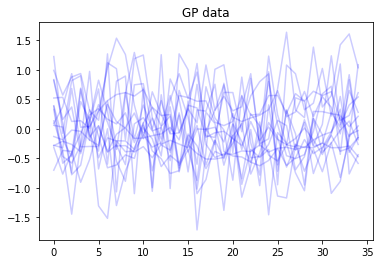

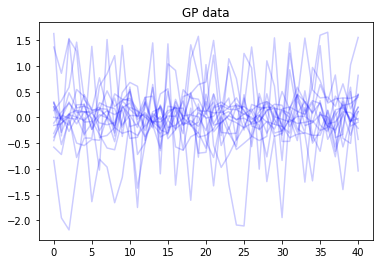

In [8]:
for batch in train_list[:2]:
  _, _, xt, yt = batch 
  for x, y in zip(xt, yt):
    plt.plot(y.cpu(), c='b', alpha=.2)
    plt.title(label='GP data')
    
  plt.show()

### Test Data

In [9]:
batch_size = 1
gptest = neural_processes.data_generator.GPCurves(batch_size, max_num_context, testing=True, dev='cuda')
test_list = [gptest.generate_curves() for _ in range(100)]

In [10]:
in_features = 1 
h_size = HIDDEN_SIZE
encoder_out = [128, 256, 512, 1024] # [h_size]*4
decoder_out = [512, 256] + [2] # [128]*2 + [2] 
mc_size = 1

In [11]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size, mc_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=128, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

### Output of predictive distribution without training

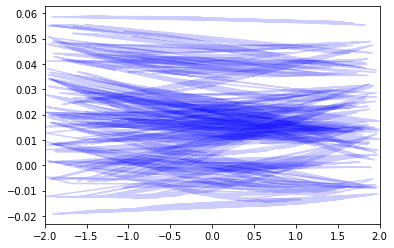

In [12]:
for i in range(50):
  xc, yc, xt, yt = train_list[i]
  z = torch.rand((16, h_size)).to(dev)
  z = z[:, None, :].expand(-1, xt.shape[1], -1)
  mu, sig, distr = np._decoder(xt, z)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.xlim(-2, 2)

In [13]:
# Xavier_Uniform weight init
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

np.apply(init_weights)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=128, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

# Training

Iteration: 0, loss: 33.613372802734375


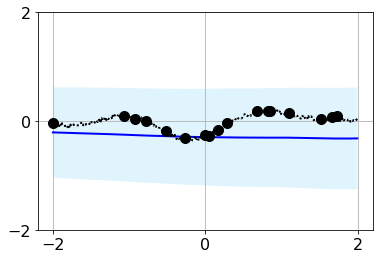

Iteration: 10000, loss: 6.173347473144531


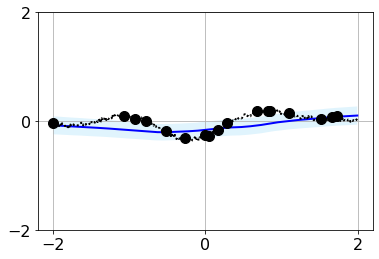

Iteration: 20000, loss: 16.65073585510254


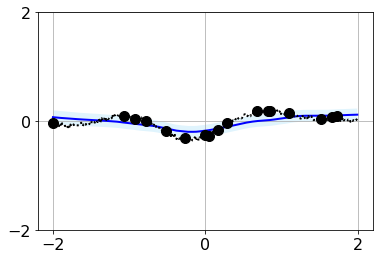

Iteration: 30000, loss: -0.9417897462844849


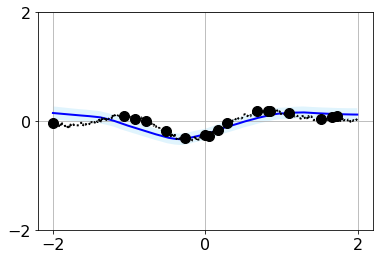

Iteration: 40000, loss: 9.149439811706543


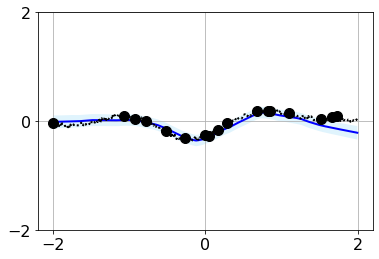

Iteration: 50000, loss: -7.623845100402832


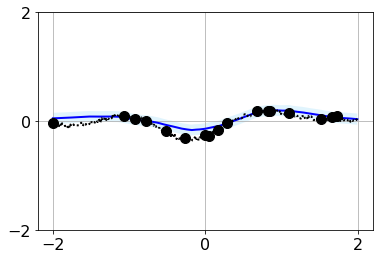

Iteration: 60000, loss: -0.0391697883605957


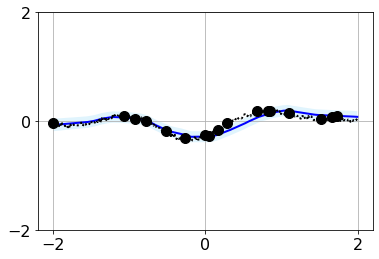

Iteration: 70000, loss: -9.04787540435791


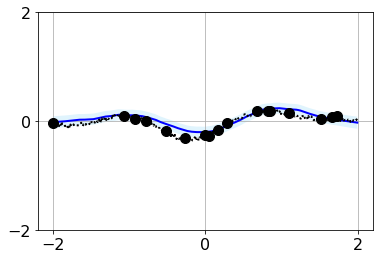

Iteration: 80000, loss: -25.476974487304688


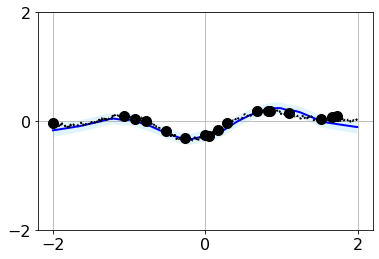

Iteration: 90000, loss: -7.930464267730713


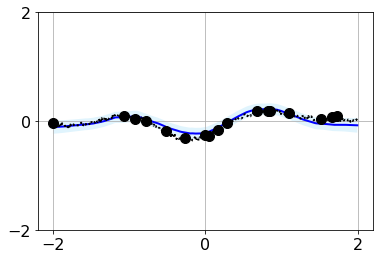

In [14]:
mu, sigma = np.fit(num_iter, save_iter, train_list, test_list)

### Save Neural Process model to Google Drive
Uncomment the code in the following cell to enable this.

In [15]:
# Mount drive
# Source: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
# from google.colab import drive
# drive.mount('/content/gdrive')

# Save model
# Source: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# !mkdir -p /content/gdrive/MyDrive/neural-processes-model
# torch.save(np, '/content/gdrive/MyDrive/neural-processes-model.pt')

In [16]:
# Hotfix for missing HTTP headers in pytorch's HTTP request for MNIST dataset download
# Source:
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### Output of predictive distribution after training given random latent Z (not related to stochastic process)


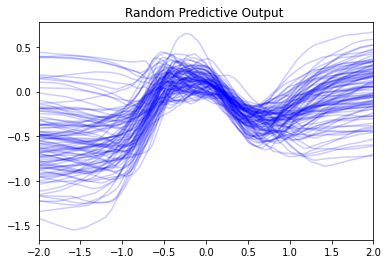

In [17]:
for i in range(len(test_list)):
  xc, yc, xt, yt = test_list[i]
  z = torch.rand((1, h_size)).to(dev)
  z = z[:, None, :].expand(-1, xt.shape[1], -1)
  mu, sig, distr = np._decoder(xt, z)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.title(label='Random Predictive Output ')
  plt.xlim(-2, 2)

### Output of predictive distribution after training given sampled latent Z

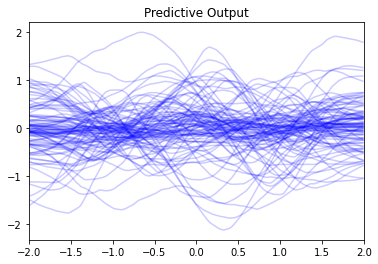

In [18]:
for i in range(len(test_list)):
  xc, yc, xt, yt = test_list[i]
  # z = torch.rand((1, h_size))
  # z = z[:, None, :].expand(-1, xt.shape[1], -1)
  (mu, sig, distr), q = np(xc, yc, xt)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.title(label='Predictive Output')
  plt.xlim(-2, 2)

# Neural Processes for MNIST

In [19]:
# ToTensor() maps to range [0, 1]
train_mnist = datasets.MNIST('./data', download=True, transform=torchvision.transforms.ToTensor()) 
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Parameters

In [20]:
if dev.type == 'cuda':
  pin_memory = True
else:
  pin_memory = False

params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory': pin_memory}
          
train_generator = torch.utils.data.DataLoader(train_mnist, **params)

In [21]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 4,
          'pin_memory': pin_memory}
          
test_generator = torch.utils.data.DataLoader(test_mnist, **params)

In [22]:
in_features = 2 
h_size = 256
encoder_out = [h_size] # [128, 256, 512, 1024] 
decoder_out = [h_size] + [2] # [512, 256] + [2] 
mc_size = 1

## Create model

In [23]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size, mc_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=3, out_features=256, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=256, out_features=256, bias=True)
    (_log_sigma): Linear(in_features=256, out_features=256, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=258, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [24]:
# Define optimizer
opt = optim.Adam(np.parameters(), lr=5e-5) 

## Fit NP model to MNIST dataset



Epoch: 0, Iteration: 0, loss: 334.873291015625
Epoch: 0, Iteration: 1000, loss: 92.96528625488281
Epoch: 0, Iteration: 2000, loss: 83.81660461425781
Epoch: 0, Iteration: 3000, loss: 81.09624481201172
Iteration: 3749, loss: 55.63764190673828
107
783


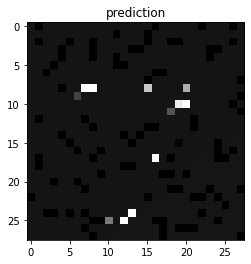

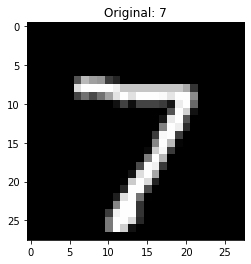

Epoch: 1, Iteration: 0, loss: 73.95045471191406
Epoch: 1, Iteration: 1000, loss: 65.1255874633789
Epoch: 1, Iteration: 2000, loss: 80.08468627929688


In [ ]:
epochs = 50
save_epoch = 5
num_iter = 60000 // 16
# mu, sigma = fit_mnist(epochs, num_iter, save_epoch, np, opt, train_generator, test_generator, dev)
mu, sigma = neural_processes.mnist.fit_mnist2(epochs, 
                                              save_epoch,
                                              np, opt, 
                                              train_generator, 
                                              test_generator, 
                                              dev)

In [ ]:
# TODO overfitting 3 classes, avg. epoch loss

In [ ]:
test_set = preprocess_mnist(test_generator, dev, train=False)

In [ ]:
xc, yc, xt, yt = test_set[6]

In [ ]:
m = torch.zeros(28, 28)
x, y = rescale(xt[0], mu.detach()[0], 'cpu')
xk, yk = rescale(xc[0], yc[0], 'cpu')

num_context = xk.shape[0]

for i, val in enumerate(x):
    
    if i < num_context:
      m[val[0], val[1]] = yk[i]
    else:
      m[val[0], val[1]] = y[i]

plt.imshow(m)